In [1]:
!pip install contractions
# !pip install nlpaug # augmenatasi
import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd

url = 'https://raw.githubusercontent.com/22bayusetia/PyCuan/main/Sentiment%20Analysis/data_finance.csv'
df = pd.read_csv(url, delimiter=',', encoding='latin-1', header=None)
# df = df.drop(0, axis=1)
df = df.drop(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3934 entries, 1 to 3934
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       3934 non-null   object
 1   1       3934 non-null   object
 2   2       3934 non-null   object
dtypes: object(3)
memory usage: 92.3+ KB


In [3]:
df.columns = ['label', 'en_text', 'id_text']
df.head()

,label,en_text,id_text
1,negative,The international electronic industry company ...,Perusahaan industri elektronik internasional E...
2,positive,With the new production plant the company woul...,"Dengan pabrik produksi baru, perusahaan akan m..."
3,positive,According to the company 's updated strategy f...,Sesuai dengan strategi terbaru perusahaan untu...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,PEMBIAYAAN UNTUK PERTUMBUHAN ASPOCOMP Aspocomp...
5,positive,"For the last quarter of 2010 , Componenta 's n...","Untuk kuartal terakhir tahun 2010, penjualan b..."


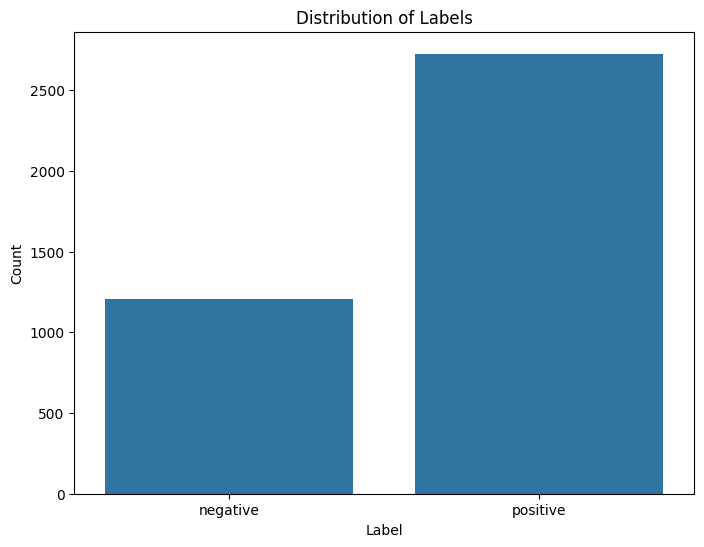

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Membuat plot distribusi kolom 'label'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

In [7]:
from bs4 import BeautifulSoup
import re
import unicodedata
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

indonesian_stopwords = set(stopwords.words('indonesian'))

def stopwords_removal(words, language):
    if language == 'english':
        list_stopwords = nltk.corpus.stopwords.words('english')
    elif language == 'indonesian':
        list_stopwords = indonesian_stopwords
    return [word for word in words if word not in list_stopwords]


def pre_process_text(text, language):
    text = text.lower()
    text = strip_html_tags(text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    text = remove_accented_chars(text)
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I | re.A)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    text = word_tokenize(text)
    text = stopwords_removal(text, language)
    return " ".join(text)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...


In [8]:
df['en_text'] = df['en_text'].apply(lambda x: pre_process_text(x, 'english'))
df['id_text'] = df['id_text'].apply(lambda x: pre_process_text(x, 'indonesian'))

df.head()

,label,en_text,id_text
1,negative,international electronic industry company elco...,perusahaan industri elektronik internasional e...
2,positive,new production plant company would increase ca...,pabrik produksi perusahaan meningkatkan kapasi...
3,positive,according company updated strategy years 20092...,sesuai strategi terbaru perusahaan 20092012 ba...
4,positive,financing aspocomp growth aspocomp aggressivel...,pembiayaan pertumbuhan aspocomp aspocomp agres...
5,positive,last quarter 2010 componenta net sales doubled...,kuartal 2010 penjualan bersih componenta berli...


In [9]:
from sklearn.utils import resample

data_majority = df[df['label'] == "positive"]
data_minority = df[df['label'] == "negative"]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)


data_minority_upsampled = resample(data_minority,
                                 replace=True,
                                 n_samples= data_majority.shape[0],
                                 random_state=123)

df_balance = pd.concat([data_majority, data_minority_upsampled])

print("After upsampling\n",df_balance.label.value_counts(),sep = "")

majority class before upsample: (2726, 3)
minority class before upsample: (1208, 3)
After upsampling
label
positive    2726
negative    2726
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balance.en_text, df_balance.label, test_size=0.2, random_state=42)

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

token = Tokenizer()
token.fit_on_texts(X_train)

In [12]:
vocab = len(token.index_word) + 1
print("Vocabulary size={}".format(len(token.word_index)))
print("Number of Documents={}".format(token.document_count))

Vocabulary size=5946
Number of Documents=4361


In [13]:
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

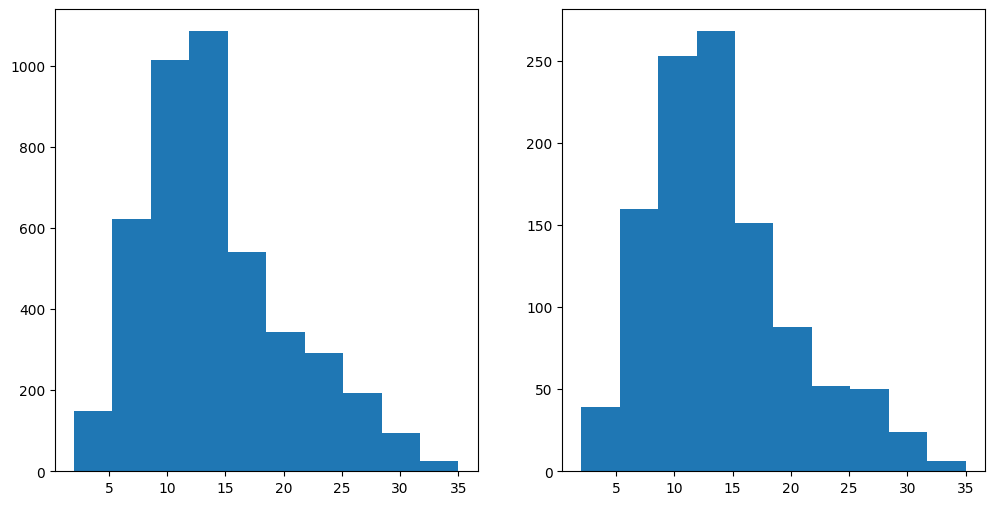

In [14]:
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 100
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_train.shape, X_test.shape

((4361, 100), (1091, 100))

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2

In [17]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [18]:
#  Modelling

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, SimpleRNN

vector_size = 300
model = Sequential()
model.add(Embedding(vocab, vector_size, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(32,2, activation="relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))
model.add(Dropout(0.5))
model.add(Dense(8, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation="relu"))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
from random import shuffle
#  tarining
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

epochs = 100
batch_size = 4

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./best_model_cnn1d.keras', monitor='val_accuracy', mode = 'max', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, batch_size=batch_size, shuffle=True, validation_split=0.1, epochs=epochs, verbose=1, callbacks=[es, mc])

Epoch 1/100
976/981 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6107 - loss: 0.6370
Epoch 1: val_accuracy improved from -inf to 0.84897, saving model to ./best_model_cnn1d.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6114 - loss: 0.6365 - val_accuracy: 0.8490 - val_loss: 0.5083
Epoch 2/100
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9097 - loss: 0.3563
Epoch 2: val_accuracy improved from 0.84897 to 0.86270, saving model to ./best_model_cnn1d.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9097 - loss: 0.3563 - val_accuracy: 0.8627 - val_loss: 0.4771
Epoch 3/100
979/981 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9455 - loss: 0.2264
Epoch 3: val_accuracy improved from 0.86270 to 0.90160, saving model to ./best_model_cnn1d.keras
981/981 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9455 - loss: 0.2264 - val_accuracy: 0.9016 - val_loss: 0.3858
Epoch 4/100
979/981 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9632 - loss: 0.1670
Epoch 4: val_

In [22]:
# Evaluation

from keras.models import load_model

saved_model = load_model('./best_model_cnn1d.keras')
train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9636 - loss: 0.2758
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9660 - loss: 0.2670
Train: 96.12%, Test: 96.33%


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Mendapatkan prediksi untuk data uji
y_pred = saved_model.predict(X_test)

# Konversi prediksi ke label kelas (binary classification)
y_pred_binary = (y_pred > 0.5).astype(int)

# Menghitung dan mencetak presisi, recall, dan f1-score
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Precision: 0.9398373983739837
Recall: 0.9948364888123924
F1-Score: 0.9665551839464883


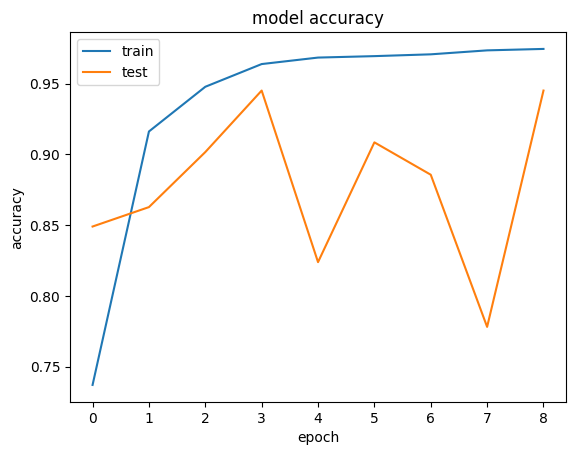

In [24]:
# Identifikasi Overfitting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


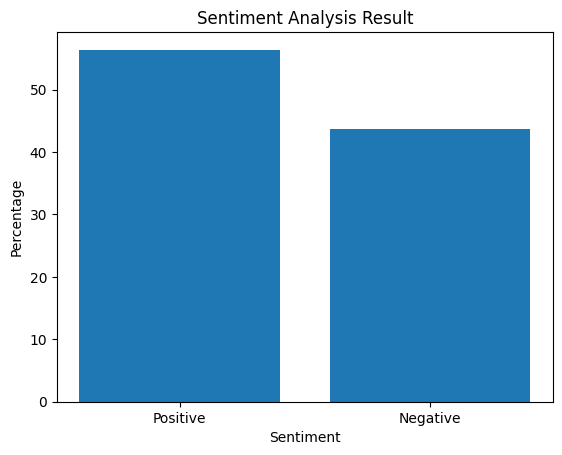

In [25]:
predicted_sentiments = saved_model.predict(X_test)
sentiments = [1 if score > 0.5 else 0 for score in predicted_sentiments]
positive_percentage = sentiments.count(1) / len(sentiments) * 100
negative_percentage = 100 - positive_percentage

plt.bar(['Positive', 'Negative'], [positive_percentage, negative_percentage])
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.title('Sentiment Analysis Result')
plt.show()

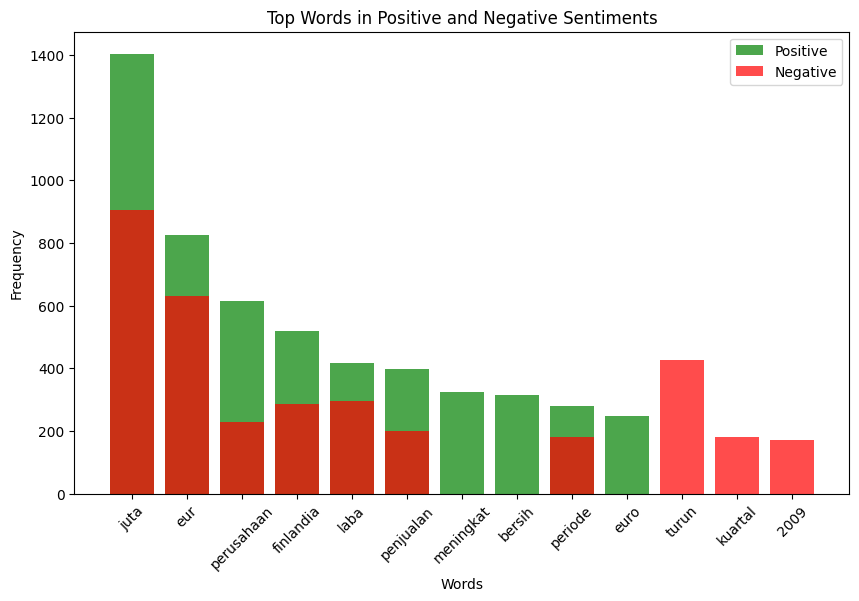

In [26]:
from collections import Counter

# Pisahkan dataset berdasarkan label sentimen
positive_texts = df[df['label'] == 'positive']['id_text']
negative_texts = df[df['label'] == 'negative']['id_text']

# Analisis teks untuk mencari kata-kata yang paling umum
def get_top_words(texts, n=10):
    all_words = " ".join(texts).split()
    word_counts = Counter(all_words)
    top_words = word_counts.most_common(n)
    return top_words

top_positive_words = get_top_words(positive_texts)
top_negative_words = get_top_words(negative_texts)

positive_words, positive_word_counts = zip(*top_positive_words)
negative_words, negative_word_counts = zip(*top_negative_words)

# Plot kata-kata yang paling umum
plt.figure(figsize=(10, 6))
plt.bar(positive_words, positive_word_counts, color='green', alpha=0.7, label='Positive')
plt.bar(negative_words, negative_word_counts, color='red', alpha=0.7, label='Negative')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top Words in Positive and Negative Sentiments')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [27]:
from wordcloud import WordCloud

# Gabungkan kata-kata dalam dataset positif dan negatif
positive_words = " ".join(positive_texts)
negative_words = " ".join(negative_texts)

# Buat Word Cloud untuk kata-kata positif
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_words)

# Buat Word Cloud untuk kata-kata negatif
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Sentiment')
plt.axis('off')

plt.subplot(122)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Sentiment')
plt.axis('off')

plt.show()


ModuleNotFoundError: No module named 'wordcloud'